# Measurement of ATP production based on given amount of TAG and glycogen
From the article, the whole process of embryonic growth produces 110 nmol of ATP which consists of 1.1 nmol of glycogen and 0.33 nmol of TAG. (v) (use glycogen and TAG)

In [13]:
# import essential packages
import cobra
import pandas as pd
import timeit
import time
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
from cobra.util.solver import linear_reaction_coefficients
from MatplotProp import CanvasStyle, PltProps
PltProps()

In [14]:
# Load Flysilico_v1 model
path = "FBA_Dmel_mapdata.json"
model = cobra.io.load_json_model(path)
model

Name,FlySilico_v1
Memory address,0x02b83a828aeb0
Number of metabolites,293
Number of reactions,363
Number of groups,0
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"cytosol, extracellular, mitochondria"


In [15]:
from cobra import Model, Reaction, Metabolite
# Best practise: SBML compliant IDs
# Copy the model for modificaitons.
fly = model.copy()

# Add an extra ATP synthesis reaction (demand reaction).
reaction = Reaction('atp_measure')
reaction.name = 'ATP_measure'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
tag = model.metabolites.get_by_id('atp[c]')
reaction.add_metabolites({
    tag: -1.0
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

# Create reactions for TAG
reaction = Reaction('EX_TAG')
reaction.name = 'TAG exchange'
reaction.subsystem = ''
reaction.lower_bound = -1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
tag_c = model.metabolites.get_by_id('tag[c]')
tag_e = Metabolite(
    'tag[e]',
    formula='C6H5O6R3',
    name='Triglyceride',
    compartment='e')

reaction.add_metabolites({
    tag_e: -1.0
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

# Transportation from extracellular space to cytosolic space.
reaction = Reaction('tm_TAG')
reaction.name = 'TAG transport'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    tag_e: -1.0,
    tag_c: 1.
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])
reaction = Reaction('EX_glyco')
reaction.name = 'Glycogen exchange'
reaction.subsystem = ''
reaction.lower_bound = -1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
glyco_c = model.metabolites.get_by_id('glycogen[c]')
glyco_e = Metabolite(
    'glycogen[e]',
    formula='C6H10O5',
    name='Glycogen',
    compartment='e')
reaction.add_metabolites({
    glyco_e: -1.0
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

# Transportation from extracellular space to cytosolic space.
reaction = Reaction('tm_glycogen')
reaction.name = 'Glycogen transport'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default # check the flux
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    glyco_e: -1.0,
    glyco_c: 1.
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

'atp[c] --> '

'tag[e] <=> '

'tag[e] --> tag[c]'

'glycogen[e] <=> '

'glycogen[e] --> glycogen[c]'

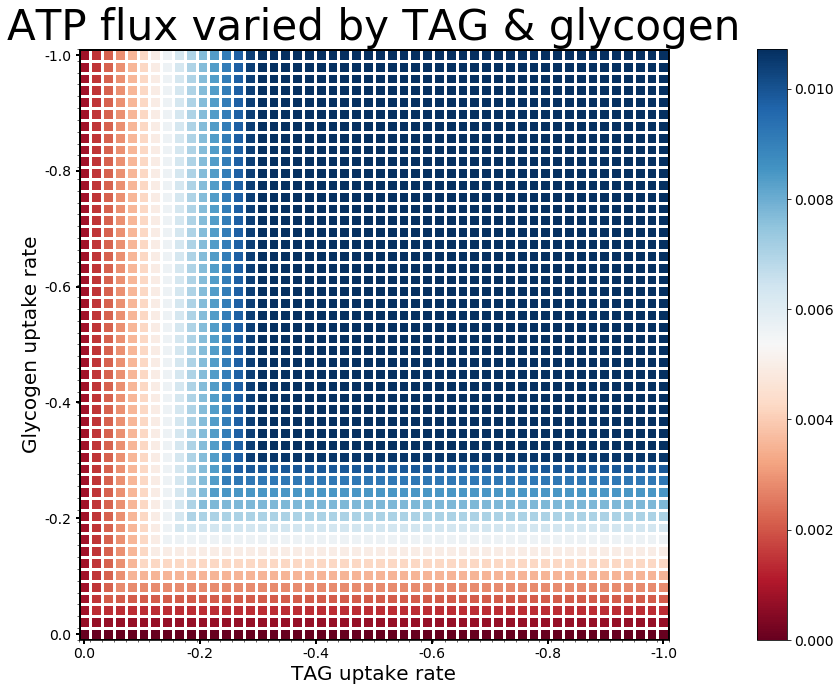

In [16]:
# Optimize the demand reaction.
fly.objective = "atp_measure"

# Settings.
sample_size = 50
para = np.linspace(0, -1, sample_size)
mat = np.zeros((sample_size, sample_size))

# Remove sucrose.
m = fly.medium
m['EX_sucr'] = 0
fly.medium = m

# Change glycogen and TAG uptake rate for measuring the ATP fluxes.
for i, vi in enumerate(reversed(para)):
    for j, vj in enumerate(para):
        fly.reactions.get_by_id('EX_glyco').lower_bound = vi
        fly.reactions.get_by_id('EX_TAG').lower_bound = vj
        sol = fly.optimize()
        mat[i, j] = sol.objective_value

# Figure settings.
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111)
im = ax.imshow(mat, cmap='RdBu')
ax.set_yticks(np.linspace(0, sample_size-1, 6))
ax.set_yticklabels(np.round(np.linspace(-1, 0, 6), 3))
ax.set_xticks(np.linspace(0, sample_size-1, 6))
ax.set_xticklabels(np.round(np.linspace(0, -1, 6), 3))
ax.set_ylabel('Glycogen uptake rate')
ax.set_xlabel('TAG uptake rate')
ax.set_title('ATP flux varied by TAG & glycogen')
CanvasStyle(ax, square=True)
ax.set_xticks(np.arange(mat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(mat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.colorbar(im)
plt.tight_layout()
plt.show()

___
## dFBA simulation with ATP synthesis reaction as demand reaction

In [17]:
# Remove all resources from the medium if needed.
# model_o = model.copy()
# m = fly.medium
# for ele in m:
#     print(ele)
#     if ele!='EX_o2' and ele!='EX_TAG' and ele!='EX_glyco':
#         m[ele] = 0
# fly.medium = m

In [33]:
# dFBA settings.
model = fly

# Remove resources from medium if needed.
m = model.medium
# m['EX_sucr'] = 0
# m['EX_glu-L(e)'] = 0
# m['EX_asn(e)'] = 0
# m['EX_asp(e)'] = 0
model.medium = m
display(model.medium)

def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    ATP, TAG, GLY, o2 = y  # expand the boundary species
    
    ATP_max_export = 1000
    model.reactions.get_by_id('atp_measure').upper_bound = ATP_max_export
    
    TAG_max_import = -0.33*TAG
    model.reactions.get_by_id('EX_TAG').lower_bound = TAG_max_import
    
    GLY_max_import = -1.1*GLY
    model.reactions.get_by_id('EX_glyco').lower_bound = GLY_max_import
    
    o2_max_import = -24*o2
    model.reactions.get_by_id('EX_o2').lower_bound = o2_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    ATP, TAG, GLY, o2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['atp_measure', 'EX_TAG', 'EX_glyco', 'EX_o2'],
            ['max', 'max', 'max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= ATP

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

{'EX_h2o': 1000.0,
 'EX_i(e)': 0.0107197,
 'EX_o2': 1000.0,
 'EX_choline(e)': 0.0158416,
 'EX_clr(e)': 0.03432158,
 'EX_fadh2(e)': 1000.0,
 'EX_ins(e)': 0.00122769,
 'EX_RIBFLV(e)': 0.00012888,
 'EX_arg(e)': 0.23361544,
 'EX_asn(e)': 0.28124216,
 'EX_asp(e)': 0.27916151,
 'EX_gln-L(e)': 0.55087471,
 'EX_glu-L(e)': 0.54748851,
 'EX_his(e)': 0.19386955,
 'EX_ile(e)': 0.3911806,
 'EX_leu(e)': 0.55304742,
 'EX_lys(e)': 0.5265047,
 'EX_met(e)': 0.09783051,
 'EX_phe(e)': 0.38025078,
 'EX_pro(e)': 0.21515964,
 'EX_ser(e)': 0.31989175,
 'EX_thr(e)': 0.4808948,
 'EX_trp(e)': 0.29024044,
 'EX_tyr(e)': 0.20507447,
 'EX_val(e)': 0.16614346,
 'EX_TAG': 1.0}

In [34]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

ts = np.linspace(0, 1000, 10000)  # Desired integration resolution and interval

# Initial condition.
y0 = [0.01, 10, 1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 1000.000: : 666it [02:23,  4.65it/s]


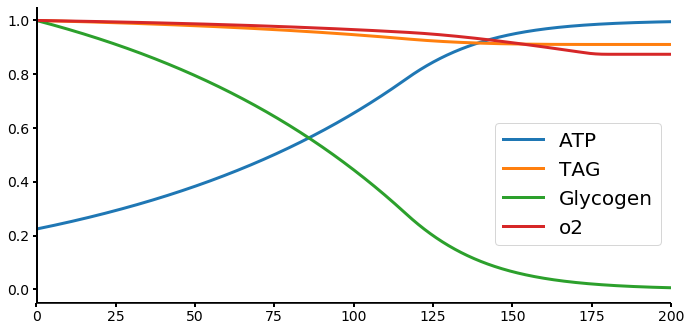

In [35]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# ax.plot(sol.t, sol.y.T[:, 0], label='ATP')
# ax.plot(sol.t, sol.y.T[:, 1], label='TAG')
# ax.plot(sol.t, sol.y.T[:, 2], label='Glycogen')
# ax.plot(sol.t, sol.y.T[:, 3], label='o2')
ax.plot(sol.t, sol.y.T[:, 0]/max(sol.y.T[:, 0]), label='ATP')
ax.plot(sol.t, sol.y.T[:, 1]/max(sol.y.T[:, 1]), label='TAG')
ax.plot(sol.t, sol.y.T[:, 2]/max(sol.y.T[:, 2]), label='Glycogen')
ax.plot(sol.t, sol.y.T[:, 3]/max(sol.y.T[:, 3]), label='o2')
ax.set_xlim([0, 200])
plt.legend(bbox_to_anchor=(1, 0.4))
# Change medium # plot the flux of extracellular sucrose
CanvasStyle(ax, square=False)

___
## dFBA simulation with ATP hydrolysis reaction as demand reaction

In [36]:
# Load Flysilico_v1 model
path = "FBA_Dmel_mapdata.json"
model = cobra.io.load_json_model(path)
model

Name,FlySilico_v1
Memory address,0x02b83d2756a00
Number of metabolites,293
Number of reactions,363
Number of groups,0
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"cytosol, extracellular, mitochondria"


In [37]:
fly = model.copy()
# Add an extra ATP synthesis reaction.
reaction = Reaction('atp_cons')
reaction.name = 'ATP_consumption'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default
# lower_bound = 0.33 * 10^-3
reaction.upper_bound = 1000.  # This is the default
atp = model.metabolites.get_by_id('atp[c]')
h2o = model.metabolites.get_by_id('h2o[c]')
pi = model.metabolites.get_by_id('pi[c]')
adp = model.metabolites.get_by_id('adp[c]')
h = model.metabolites.get_by_id('h[c]')

# reaction.add_metabolites({
#     atp: -1.0,
#     h2o: -1.0,
#     pi: +1.0,
#     adp: +1.0,
#     h: +1.0,
# })
reaction.add_metabolites({
    atp: -1.0,
    pi: +1.0,
    adp: +1.0,
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])


# Create reactions for TAG
reaction = Reaction('EX_TAG')
reaction.name = 'TAG exchange'
reaction.subsystem = ''
reaction.lower_bound = -1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
tag_c = model.metabolites.get_by_id('tag[c]')
tag_e = Metabolite(
    'tag[e]',
    formula='C6H5O6R3',
    name='Triglyceride',
    compartment='e')

reaction.add_metabolites({
    tag_e: -1.0
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

# Transportation from extracellular space to cytosolic space.
reaction = Reaction('tm_TAG')
reaction.name = 'TAG transport'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    tag_e: -1.0,
    tag_c: 1.
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])
#tag[e] --> 
# tag[e] --> tag[c]
#
reaction = Reaction('EX_glyco')
reaction.name = 'Glycogen exchange'
reaction.subsystem = ''
reaction.lower_bound = -1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
glyco_c = model.metabolites.get_by_id('glycogen[c]')
glyco_e = Metabolite(
    'glycogen[e]',
    formula='C6H10O5',
    name='Glycogen',
    compartment='e')
reaction.add_metabolites({
    glyco_e: -1.0
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

# Transportation from extracellular space to cytosolic space.
reaction = Reaction('tm_glycogen')
reaction.name = 'Glycogen transport'
reaction.subsystem = ''
reaction.lower_bound = 0.  # This is the default # check the flux
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    glyco_e: -1.0,
    glyco_c: 1.
})

display(reaction.reaction)  # This gives a string representation of the reaction
fly.add_reactions([reaction])

'atp[c] --> adp[c] + pi[c]'

'tag[e] <=> '

'tag[e] --> tag[c]'

'glycogen[e] <=> '

'glycogen[e] --> glycogen[c]'

In [82]:
# fly.objective = "atp_cons"
# sample_size = 50
# para = np.linspace(0, -1, sample_size)
# mat = np.zeros((sample_size, sample_size))
# m = fly.medium
# m['EX_sucr'] = 0
# fly.medium = m
# for i, vi in enumerate(reversed(para)):
#     for j, vj in enumerate(para):
#         fly.reactions.get_by_id('EX_glyco').lower_bound = vi
#         fly.reactions.get_by_id('EX_TAG').lower_bound = vj
#         sol = fly.optimize()
#         mat[i, j] = sol.objective_value
# #         print(sol.objective_value)
        
# fig = plt.figure(figsize=(25, 10))
# ax = fig.add_subplot(111)
# im = ax.imshow(mat, cmap='RdBu')
# ax.set_yticks(np.linspace(0, sample_size-1, 6))
# ax.set_yticklabels(np.round(np.linspace(-1, 0, 6), 3))
# ax.set_xticks(np.linspace(0, sample_size-1, 6))
# ax.set_xticklabels(np.round(np.linspace(0, -1, 6), 3))
# ax.set_ylabel('Glycogen uptake rate')
# ax.set_xlabel('TAG uptake rate')
# ax.set_title('ATP hydrolysis')
# CanvasStyle(ax, square=True)
# ax.set_xticks(np.arange(mat.shape[1]+1)-.5, minor=True)
# ax.set_yticks(np.arange(mat.shape[0]+1)-.5, minor=True)
# ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
# plt.colorbar(im)
# plt.tight_layout()
# plt.show()


# fly.reactions.get_by_id('EX_glyco').lower_bound = -0.11
# fly.reactions.get_by_id('EX_TAG').lower_bound = -0.033
# sol = fly.optimize()
# display(sol.objective_value)
# display(sol.fluxes['tm_TAG'])
# display(sol.fluxes['tm_glycogen'])

In [38]:
# model_o = model.copy()
# m = fly.medium
# for ele in m:
#     print(ele)
#     if ele!='EX_o2' and ele!='EX_TAG' and ele!='EX_glyco':
#         m[ele] = 0
# fly.medium = m

In [42]:
import cobra
from cobra.test import create_test_model
# model = create_test_model('textbook')
# model = cobra.io.load_json_model(path)
model = fly
m = model.medium
model.medium['EX_sucr'] = 0
# m['EX_glu-L(e)'] = 0
# m['EX_asn(e)'] = 0
# m['EX_asp(e)'] = 0
model.medium = m
display(model.medium)
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    ATP, TAG, GLY, o2 = y  # expand the boundary species
    
    ATP_max_export = 1*ATP
    model.reactions.get_by_id('atp_cons').upper_bound = ATP_max_export
    
    TAG_max_import = -0.33*TAG#-10 * TAG / (5 + TAG) # use -1
    model.reactions.get_by_id('EX_TAG').lower_bound = TAG_max_import
#     print('bug', TAG_max_import)
    GLY_max_import = -1.1*GLY#-10 * GLY / (5 + GLY) # use -1
    model.reactions.get_by_id('EX_glyco').lower_bound = GLY_max_import
    
    o2_max_import = -24*o2
    model.reactions.get_by_id('EX_o2').lower_bound = o2_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    ATP, TAG, GLY, o2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['atp_cons', 'EX_TAG', 'EX_glyco', 'EX_o2'], ['max', 'max', 'max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= ATP

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

{'EX_h2o': 1000.0,
 'EX_i(e)': 0.0107197,
 'EX_o2': 1000.0,
 'EX_sucr': 2.21240544,
 'EX_choline(e)': 0.0158416,
 'EX_clr(e)': 0.03432158,
 'EX_fadh2(e)': 1000.0,
 'EX_ins(e)': 0.00122769,
 'EX_RIBFLV(e)': 0.00012888,
 'EX_arg(e)': 0.23361544,
 'EX_asn(e)': 0.28124216,
 'EX_asp(e)': 0.27916151,
 'EX_gln-L(e)': 0.55087471,
 'EX_glu-L(e)': 0.54748851,
 'EX_his(e)': 0.19386955,
 'EX_ile(e)': 0.3911806,
 'EX_leu(e)': 0.55304742,
 'EX_lys(e)': 0.5265047,
 'EX_met(e)': 0.09783051,
 'EX_phe(e)': 0.38025078,
 'EX_pro(e)': 0.21515964,
 'EX_ser(e)': 0.31989175,
 'EX_thr(e)': 0.4808948,
 'EX_trp(e)': 0.29024044,
 'EX_tyr(e)': 0.20507447,
 'EX_val(e)': 0.16614346,
 'EX_TAG': 1000.0,
 'EX_glyco': 1000.0}

In [43]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

ts = np.linspace(0, 2, 10)  # Desired integration resolution and interval
y0 = [100, 1, 1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 0.100: : 548it [02:00,  4.53it/s]


Infeasible: None (infeasible)

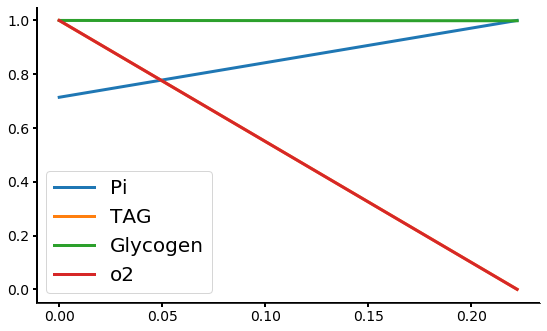

In [81]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
# ax.plot(sol.t, sol.y.T[:, 0], label='ATP')
# ax.plot(sol.t, sol.y.T[:, 1], label='TAG')
# ax.plot(sol.t, sol.y.T[:, 2], label='Glycogen')
# ax.plot(sol.t, sol.y.T[:, 3], label='o2')
ax.plot(sol.t, sol.y.T[:, 0]/max(sol.y.T[:, 0]), label='Pi')
ax.plot(sol.t, sol.y.T[:, 1]/max(sol.y.T[:, 1]), label='TAG')
ax.plot(sol.t, sol.y.T[:, 2]/max(sol.y.T[:, 2]), label='Glycogen')
ax.plot(sol.t, sol.y.T[:, 3]/max(sol.y.T[:, 3]), label='o2')
plt.legend()
# Change medium # plot the flux of extracellular sucrose
CanvasStyle(ax, square=False)